# PetFinder.my Pawpularity Score / Predict

## Imports

In [1]:
# Imports
import os
import numpy as np
from IPython.display import display

# Import landmark recognition lib
import petfinder_pawpularity_lib as mllib
tf_strategy = mllib.tf_strategy()

'TensorFlow Version: 2.6.0'

'TensorFlow Strategy: _DefaultDistributionStrategy'

In [2]:
# Enable retina display
%config InlineBackend.figure_format = "retina"

# Load Tensorboard
%load_ext tensorboard

## Settings

### Settings definitions

In [3]:
# Settings Map
if "settingsMap" not in globals(): settingsMap = {}

In [4]:
# predict-local-cut
settingsMap["predict-local-cut"] = {
    "debug": True,
    "model_load_dir": os.path.join("models"),
    "model_save_dir": os.path.join("models"),
    "dataset_dir_src": os.path.join("..", "input", "petfinder-pawpularity-score"),
    "dataset_dir_cut": os.path.join("..", "input", "petfinder-pawpularity-score"),
    "dataset_batch_size": 16,
    "dataset_image_size": (100, 100),
    "dataset_cut_ratio": 0.2,
    "dataset_shrink_ratio": 1.0,
    "dataset_split_ratios": [0.7, 0.20, 0.1],
    "dataset_shuffle": False,
    "dataset_shuffle_seed": np.random.seed(42),
    "dataset_prefetch": mllib.tf.data.AUTOTUNE,
    "score_sample_size": 10,
    "cleanup_data_flag": False,
}

In [5]:
# predict-local-full
settingsMap["predict-local-full"] = {
    "debug": False,
    "model_load_dir": os.path.join("models"),
    "model_save_dir": os.path.join("models"),
    "dataset_dir_src": os.path.join("..", "input", "petfinder-pawpularity-score"),
    "dataset_dir_cut": os.path.join("..", "input", "petfinder-pawpularity-score"),
    "dataset_batch_size": 64,
    "dataset_image_size": (150, 150),
    "dataset_cut_ratio": 1.0,
    "dataset_shrink_ratio": 1.0,
    "dataset_split_ratios": [0.90, 0.0, 0.10],
    "dataset_shuffle": False,
    "dataset_shuffle_seed": np.random.seed(42),
    "dataset_prefetch": mllib.tf.data.AUTOTUNE,
    "score_sample_size": 1,
    "cleanup_data_flag": False,
}

In [6]:
# predict-remote-cut
settingsMap["predict-remote-cut"] = {
    "debug": False,
    "model_load_dir": os.path.join("..", "input", "petfinder-pawpularity-model", "models"),
    "model_save_dir": os.path.join("models"),
    "dataset_dir_src": os.path.join("..", "input", "petfinder-pawpularity-score"),
    "dataset_dir_cut": os.path.join("dataset", "petfinder-pawpularity-score"),
    "dataset_batch_size": 64,
    "dataset_image_size": (150, 150),
    "dataset_cut_ratio": 0.2,
    "dataset_shrink_ratio": 1.0,
    "dataset_split_ratios": [0.7, 0.20, 0.1],
    "dataset_shuffle": False,
    "dataset_shuffle_seed": np.random.seed(42),
    "dataset_prefetch": mllib.tf.data.AUTOTUNE,
    "score_sample_size": 10,
    "cleanup_data_flag": True,
}

In [7]:
# predict-remote-full
settingsMap["predict-remote-full"] = {
    "debug": False,
    "model_load_dir": os.path.join("..", "input", "petfinder-pawpularity-model", "models"),
    "model_save_dir": os.path.join("models"),
    "dataset_dir_src": os.path.join("..", "input", "petfinder-pawpularity-score"),
    "dataset_dir_cut": os.path.join("dataset", "petfinder-pawpularity-score"),
    "dataset_batch_size": 64,
    "dataset_image_size": (150, 150),
    "dataset_cut_ratio": 1.0,
    "dataset_shrink_ratio": 1.0,
    "dataset_split_ratios": [0.90, 0.0, 0.10],
    "dataset_shuffle": False,
    "dataset_shuffle_seed": np.random.seed(42),
    "dataset_prefetch": 1,
    "score_sample_size": 10,
    "cleanup_data_flag": True,
}

### Selected settings

In [8]:
# Mode
mode = "predict-local-cut"

In [9]:
# Selected settings
settings = settingsMap[mode]
display(settings)

# Debug
debug = settings["debug"]

{'debug': True,
 'model_load_dir': 'models',
 'model_save_dir': 'models',
 'dataset_dir_src': '../input/petfinder-pawpularity-score',
 'dataset_dir_cut': '../input/petfinder-pawpularity-score',
 'dataset_batch_size': 16,
 'dataset_image_size': (100, 100),
 'dataset_cut_ratio': 0.2,
 'dataset_shrink_ratio': 1.0,
 'dataset_split_ratios': [0.7, 0.2, 0.1],
 'dataset_shuffle': False,
 'dataset_shuffle_seed': None,
 'dataset_prefetch': -1,
 'score_sample_size': 10,
 'cleanup_data_flag': False}

## Prepare data

'../input/petfinder-pawpularity-score-cut-0.200000'

'Load training data from ../input/petfinder-pawpularity-score-cut-0.200000/train.csv'

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977,32f4f6afaae9f0633ffd11d3e8589689,0,1,1,1,0,1,0,0,0,0,0,0,45
1978,32f7f313e386e95dad34ffed898fe43c,0,1,1,1,0,0,0,1,1,1,0,0,57
1979,32fa718066e9373a5af30dbb77bf32ee,0,0,0,1,0,0,0,0,0,1,1,0,59
1980,32fb50499ca324b5b49ac5b00a63a923,0,1,1,1,0,1,0,0,0,1,1,0,18


Cause: could not parse the source code of <function <lambda> at 0x7f8da512d3a0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f8da512d3a0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Train / Validate / Test datasets items: 1376 / 384 / 192

Train dataset:


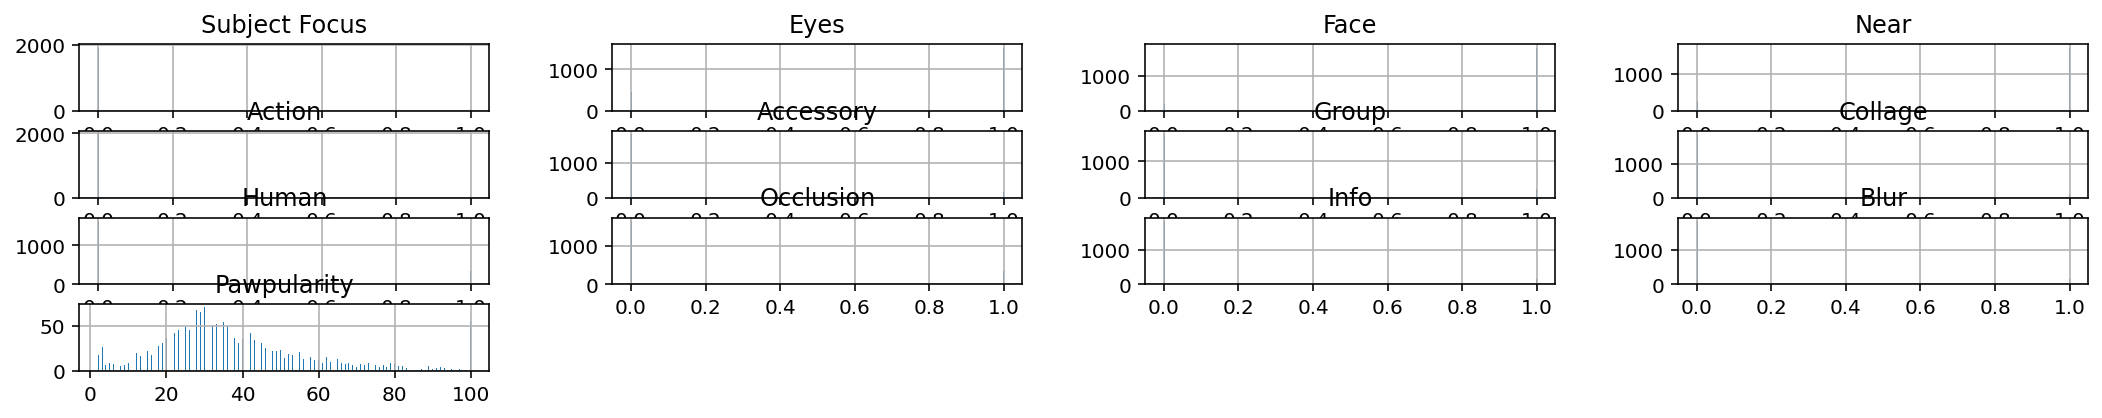

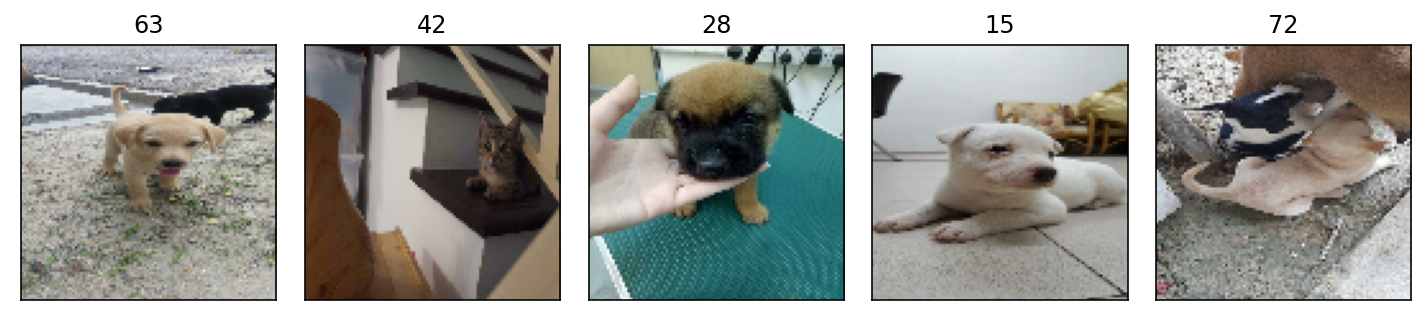

Validate dataset:


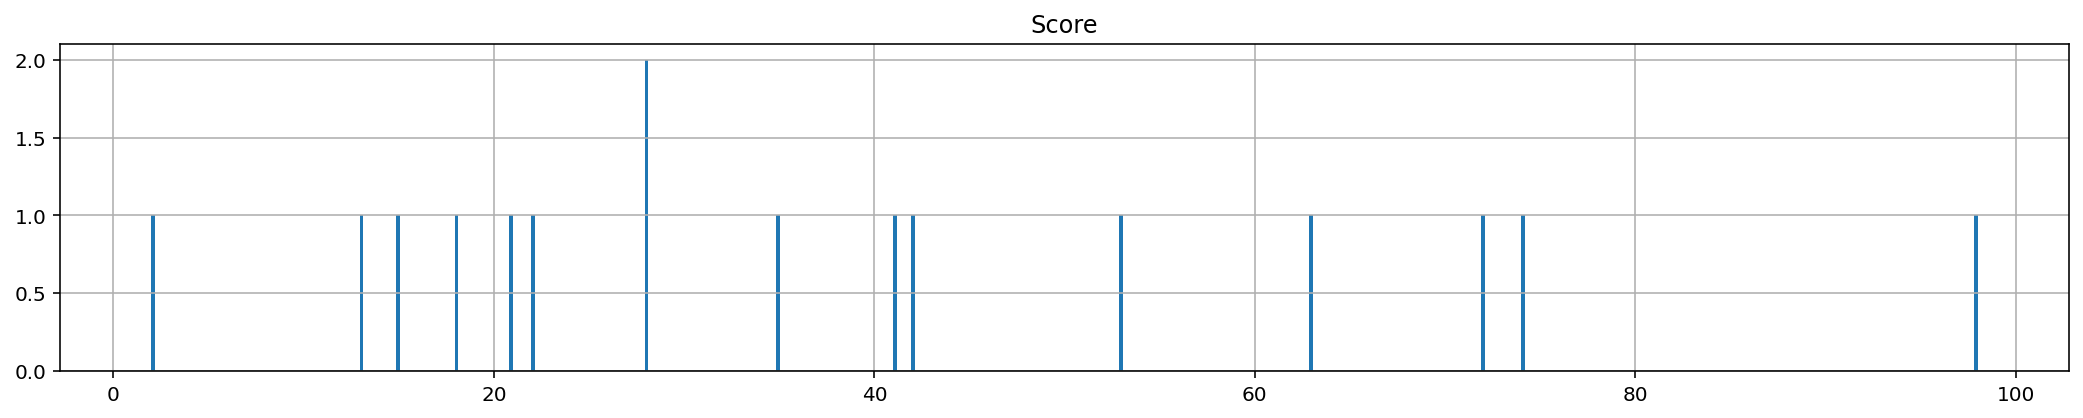

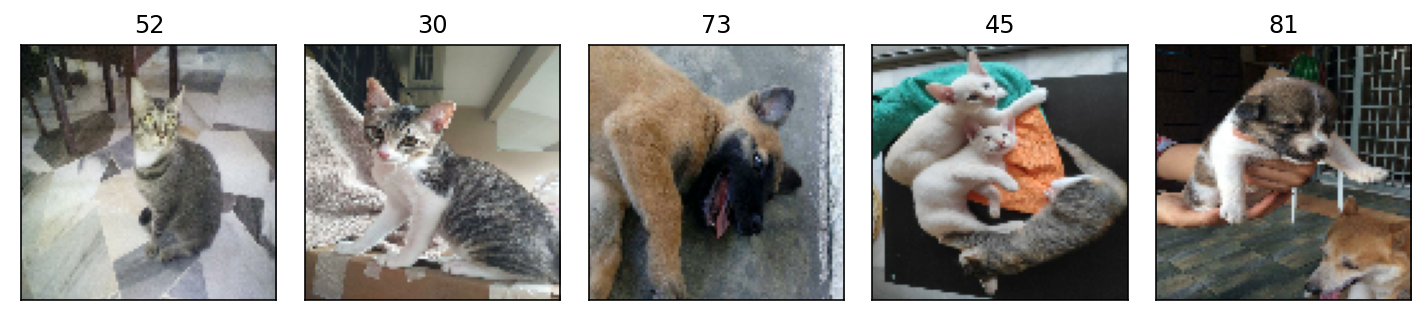

Test dataset:


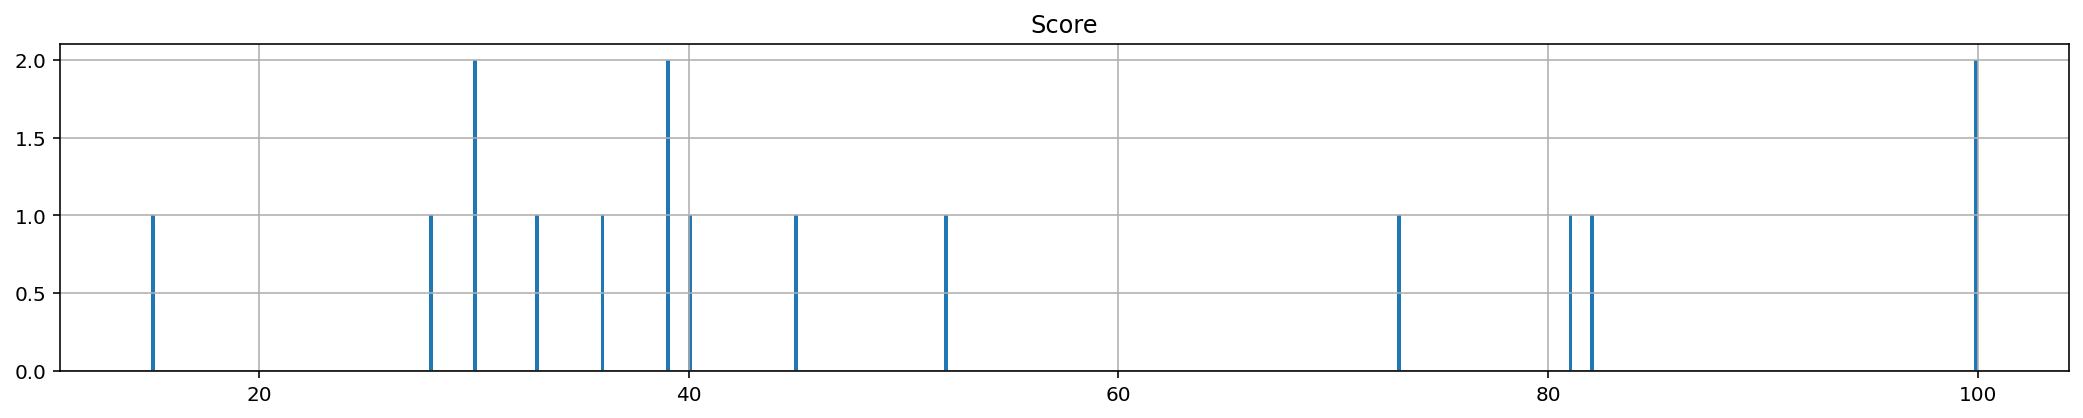

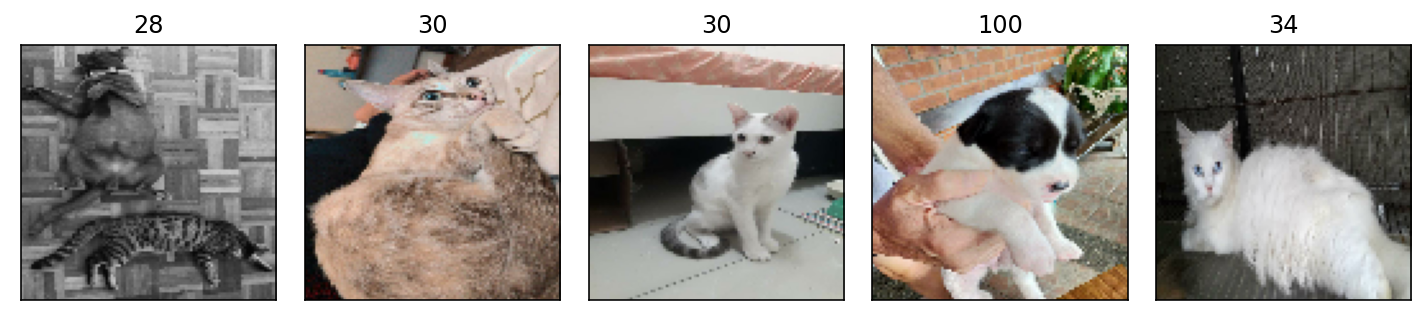

CPU times: user 19 s, sys: 1.18 s, total: 20.2 s
Wall time: 18 s


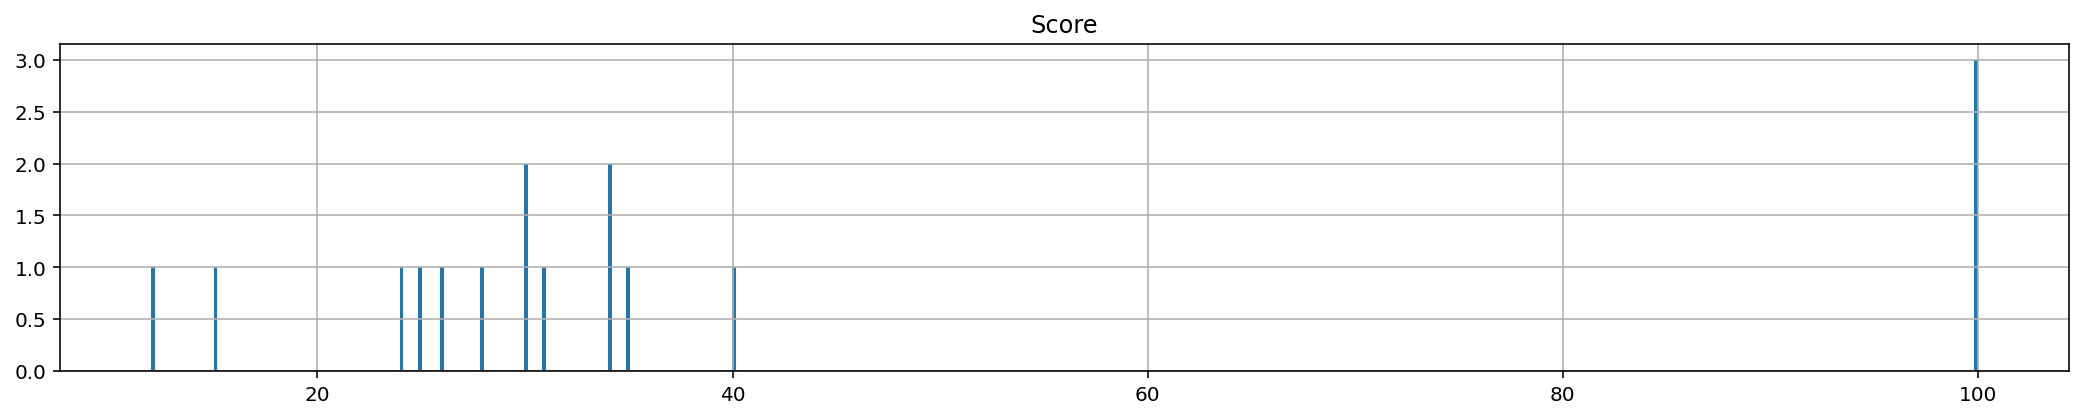

In [10]:
%%time
# Cut training data
dataset_dir = mllib.cut_training_data(
    cut_ratio=settings["dataset_cut_ratio"], 
    dataset_dir_src=settings["dataset_dir_src"], 
    dataset_dir_cut=settings["dataset_dir_cut"]
)
display(dataset_dir)

# Train data
training_data = mllib.load_training_data(dataset_dir)
if debug: 
    display(training_data)
    training_data.hist(bins=500, figsize=(18,3))

# Make training data
train_dataset, validate_dataset, test_dataset = mllib.make_training_validate_test_data(
    dataset=mllib.load_training_dataset(
        dataset_dir=dataset_dir,
        mapping_data=training_data,
        batch_size=settings["dataset_batch_size"],
        shuffle=settings["dataset_shuffle"],
        seed=settings["dataset_shuffle_seed"],
        image_size=settings["dataset_image_size"],
    ),
    split_ratios=settings["dataset_split_ratios"],
    shrink_ratio=settings["dataset_shrink_ratio"],
    prefetch=settings["dataset_prefetch"],
    map_fn=lambda image, features, score, file_id: (image, score, file_id),
)

# Training data infos
print("Train / Validate / Test datasets items: %s / %s / %s" % (
    settings["dataset_batch_size"] * train_dataset().cardinality().numpy(), 
    settings["dataset_batch_size"] * validate_dataset().cardinality().numpy(), 
    settings["dataset_batch_size"] * test_dataset().cardinality().numpy()
))
if debug:
    print("")
    print("Train dataset:")
    mllib.plot_images_scores_from_dataset(train_dataset().take(1))
    print("Validate dataset:")
    mllib.plot_images_scores_from_dataset(validate_dataset().take(1))
    print("Test dataset:")
    mllib.plot_images_scores_from_dataset(test_dataset().take(1))

## Predict

In [11]:
# Prepare model parameters
def get_model_parameters(settings):
    dataset_image_size = settings["dataset_image_size"]
    model_parameters = {
        "model_prefix": "model_1_xception_%0.6f" % settings["dataset_cut_ratio"],
        "input_shape": [dataset_image_size[0], dataset_image_size[1], 3],
        "output_size": 1,
        "preload_weights": None,
        "dropout_rate": 0.0,
    }
    model_name = mllib.get_model_name(model_parameters)
    model_parameters["model_name"] = model_name
    return model_parameters
    
model_parameters = get_model_parameters(settings)
display(model_parameters)

{'model_prefix': 'model_1_xception_0.200000',
 'input_shape': [100, 100, 3],
 'output_size': 1,
 'preload_weights': None,
 'dropout_rate': 0.0,
 'model_name': 'model_1_xception_0.200000'}

In [12]:
%%time
# Load model
with tf_strategy.scope():
    model = mllib.setup_model(model_parameters)
    model_file = mllib.load_model(model, settings["model_load_dir"])
    print("Loaded Weights: %s" % model_file)

Model: "model_1_xception_0.200000"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 100, 100, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 100, 100, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)   

*** Test Image # 1
>>> FAILURE
>>> Predicted score: 22 vs 43


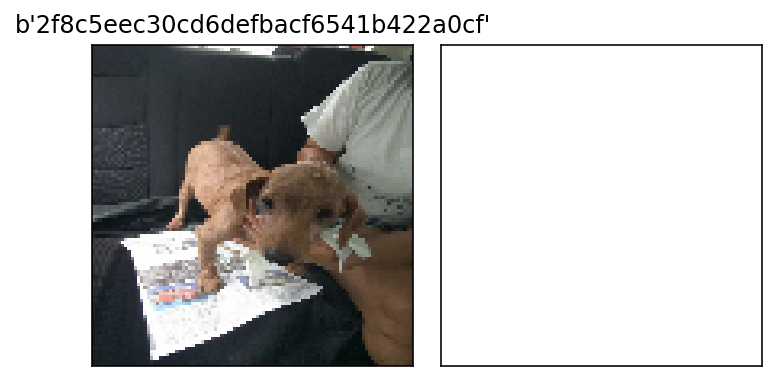


*** Test Image # 2
>>> FAILURE
>>> Predicted score: 34 vs 59


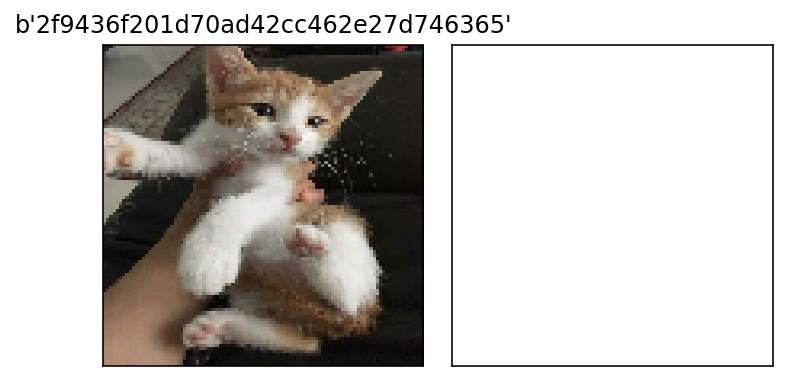


*** Test Image # 3
>>> FAILURE
>>> Predicted score: 42 vs 58


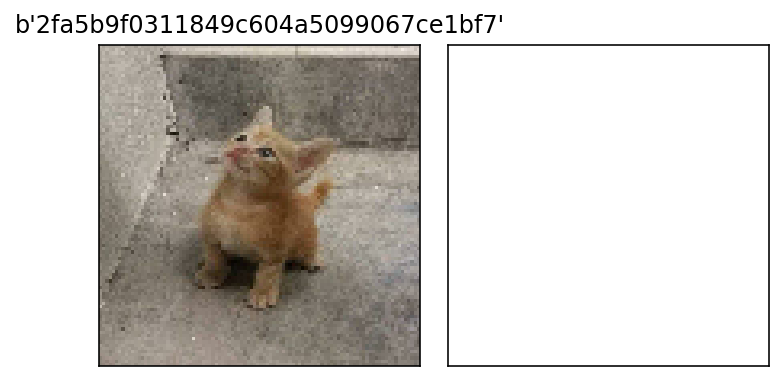


*** Test Image # 4
>>> SUCCESS
>>> Predicted score: 28 vs 27


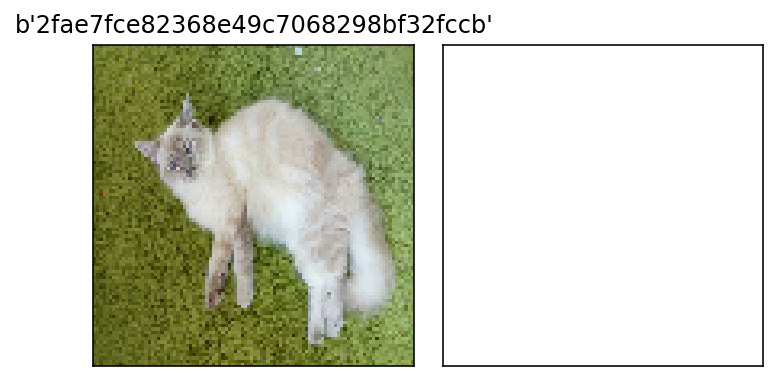


*** Test Image # 5
>>> FAILURE
>>> Predicted score: 36 vs 12


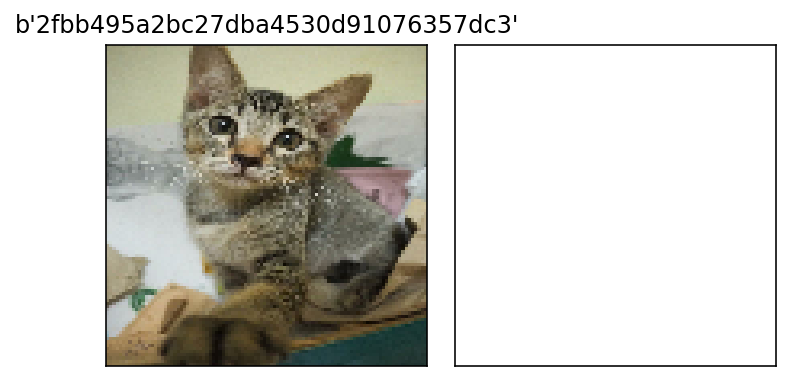


CPU times: user 6.49 s, sys: 979 ms, total: 7.47 s
Wall time: 4.12 s


In [13]:
%%time
# Predict on test dataset
if debug:
    with tf_strategy.scope():
        images, scores, file_ids, *_ = mllib.load_images_scores_from_dataset(test_dataset().shuffle(100).take(1))
        for index in range(len(images[:5])):
            print("*** Test Image #",index+1)
            mllib.predict(
                model=model, 
                image=images[index],
                label=file_ids[index],
                true_score=scores[index], 
            )
            print("")

## Score

### Train

In [14]:
%%time
# Score train submission data
train_score, train_scored_data = mllib.score_submission_data(
    submission_data=mllib.infer_submission_data(
        dataset=train_dataset,
        model=model, 
        take=settings["score_sample_size"]
    ), 
    training_data=training_data
)
display("Train Submission RMSE Score: %f" % train_score)
if debug: display(train_scored_data)

'Train Submission RMSE Score: 20.172336'

,index,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,predicted_Pawpularity
0,0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63.0,36.00
1,1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42.0,42.91
2,2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28.0,53.51
3,3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15.0,51.98
4,4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72.0,42.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,155,046d156532ddc82dd2e95a7cb624fd7d,0,1,1,1,0,0,0,0,0,0,0,0,45.0,37.61
156,156,046d3fb0560082412a5fc52cd694eb34,0,0,1,1,0,0,0,0,0,0,0,0,2.0,33.30
157,157,04719a161572a4f9f9a1252d0e2eb24c,0,1,1,1,0,0,0,0,0,0,0,0,22.0,8.33
158,158,047a81a2d5baa5d7526f582fd7bd4805,0,1,1,0,0,0,0,0,0,0,0,0,61.0,34.00


CPU times: user 17.4 s, sys: 3.58 s, total: 21 s
Wall time: 6.85 s


### Validate

In [15]:
%%time
# Score validate submission data
validate_score, validate_scored_data = mllib.score_submission_data(
    submission_data=mllib.infer_submission_data(
        dataset=validate_dataset,
        model=model, 
        take=settings["score_sample_size"]
    ), 
    training_data=training_data
)
display("Validate Submission RMSE Score: %f" % validate_score)
if debug: display(validate_scored_data)

'Validate Submission RMSE Score: 24.090653'

,index,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,predicted_Pawpularity
0,0,2352855e6c6fda783f78bf6bcfd25c93,0,1,1,1,0,0,0,0,0,0,0,0,52.0,25.38
1,1,23549c83770e38d08c6265b009b4f463,0,1,1,1,0,0,0,0,0,0,0,0,30.0,16.76
2,2,235c64e9132749344e2257ccd6d5cf0c,0,0,1,1,0,0,0,0,0,0,0,0,73.0,43.40
3,3,235f5c8eecf9b2951f8e783abc35c964,0,1,1,1,0,0,1,0,0,0,0,0,45.0,27.72
4,4,2362b7b2c8c2178e9d004e5bfd7e09bf,0,1,1,1,0,0,1,0,1,1,0,0,81.0,32.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,155,2730dbc1ad5e7463a6b31949e7dc1827,0,1,1,1,0,0,0,0,0,0,0,0,34.0,36.07
156,156,2736582918e28a679bc900545a94ff1b,0,1,1,1,0,0,0,0,1,1,0,0,51.0,42.42
157,157,273a7fb05551ea427a2ad444e2375fd7,0,1,1,1,0,0,0,0,0,0,0,0,25.0,55.81
158,158,273d8522a2221d1d8ad0a2f60ac14abe,0,1,1,1,0,0,0,0,0,0,0,0,12.0,29.52


CPU times: user 17.3 s, sys: 3.46 s, total: 20.7 s
Wall time: 6.23 s


### Test

In [16]:
%%time
# Score test submission data
test_score, test_scored_data = mllib.score_submission_data(
    submission_data=mllib.infer_submission_data(
        dataset=test_dataset,
        model=model, 
        take=settings["score_sample_size"]
    ), 
    training_data=training_data
)
display("Test Submission RMSE Score: %f" % test_score)
if debug: display(test_scored_data)

'Test Submission RMSE Score: 20.104870'

,index,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,predicted_Pawpularity
0,0,2cb321cc9160eb372e67cf48386bf485,0,0,0,1,0,0,0,0,0,0,0,0,28.0,41.83
1,1,2cba0db3ca99db5a699a056bfe144db9,0,1,1,1,0,0,0,0,0,0,0,0,30.0,20.51
2,2,2cba27edc6487a6a0a09428fcb37aac3,0,1,1,1,0,0,0,0,0,0,0,0,30.0,32.42
3,3,2cbf22ad632308b3c15608ed2b7cb0a6,0,0,1,1,0,0,0,0,1,1,0,1,100.0,27.24
4,4,2cbf55c28166ee59fe7f3d55b36303cd,0,1,1,1,0,0,0,0,0,0,0,0,34.0,46.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,155,30cc662d0034a1089905b99fb90a49f4,0,1,1,1,0,0,0,0,0,0,0,0,27.0,38.65
156,156,30dafe3fde143cf3cf75814dbebdd6bb,0,1,1,1,0,1,0,0,0,0,0,0,52.0,44.38
157,157,30df9c134ec437c0a448aad80867cd1c,0,1,1,1,0,0,0,0,0,0,0,0,30.0,47.01
158,158,30e50fc899c217f4bcd85c668c9bb517,0,0,0,0,0,0,0,0,0,0,0,0,32.0,29.41


CPU times: user 18.6 s, sys: 3.65 s, total: 22.2 s
Wall time: 6.82 s


## Cleanup

In [17]:
%%time
if settings["cleanup_data_flag"]: 
    mllib.delete_training_data(cut_ratio=settings["dataset_cut_ratio"], dataset_dir_cut=settings["dataset_dir_cut"])

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.39 µs
